# Hands-On NLP

## Class 2

### Ben Kabongo Buzangu
**Université Paris-Saclay, M1 DS, 22210136**

- Embeddings from scratch

- Classifications with embeddings

In [1]:
import re
import unicodedata
from collections import Counter
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/benkabongo25/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

# %load_ext blackcellmagic

In [4]:
DATA = Path("data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [5]:
TEXT_P.mkdir(exist_ok=True)

# Getting the data

In [6]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n..."
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic..."


### Tokenizing

In [7]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = DATA / "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [8]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...,"[Q, :, Can, anyone, identify, what, Chinese, m...",942599,51253
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...,"[Q, :, Glue-up, for, butcher, block-style, cou...",1390532,32318
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...,"[Q, :, How, is, this, torque, value, arrived, ...",1526904,53833
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n...","[Q, :, When, and, why, did, people, stopped, u...",1445136,62464
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...,"[Q, :, Help, reading, an, eyeglass, prescripti...",1714931,66006
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic...","[Q, :, Qual, a, origem, da, expressão, ``, o, ...",907242,60282


# Vectorization

#### 🚧 TODO: Think about how to vectorize text

- Try counting words in the stackoverflow corpus based on a given vocabulary

- Apply reduction techniques to reduce the dimensionality to 2 dimensions (e.g., PCA)

- Plot the 2D vectors

In [9]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)
wc_df = pd.DataFrame(index=df.index)
for w in words:
    wc_df[w] = df['text'].str.count(w)

In [10]:
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,3120,140,9,191,44,4,26,0,273780
woodworking,10,11840,4,19,14,0,52,0,435118
robotics,2,50,7547,25,27,46,8,0,453376
hsm,53,61,6,990,1099,1620,37,1,423543
health,62,33,3,213,305,6,2931,1,544730
portuguese,7,34,3,15,4,2,13,187,339334


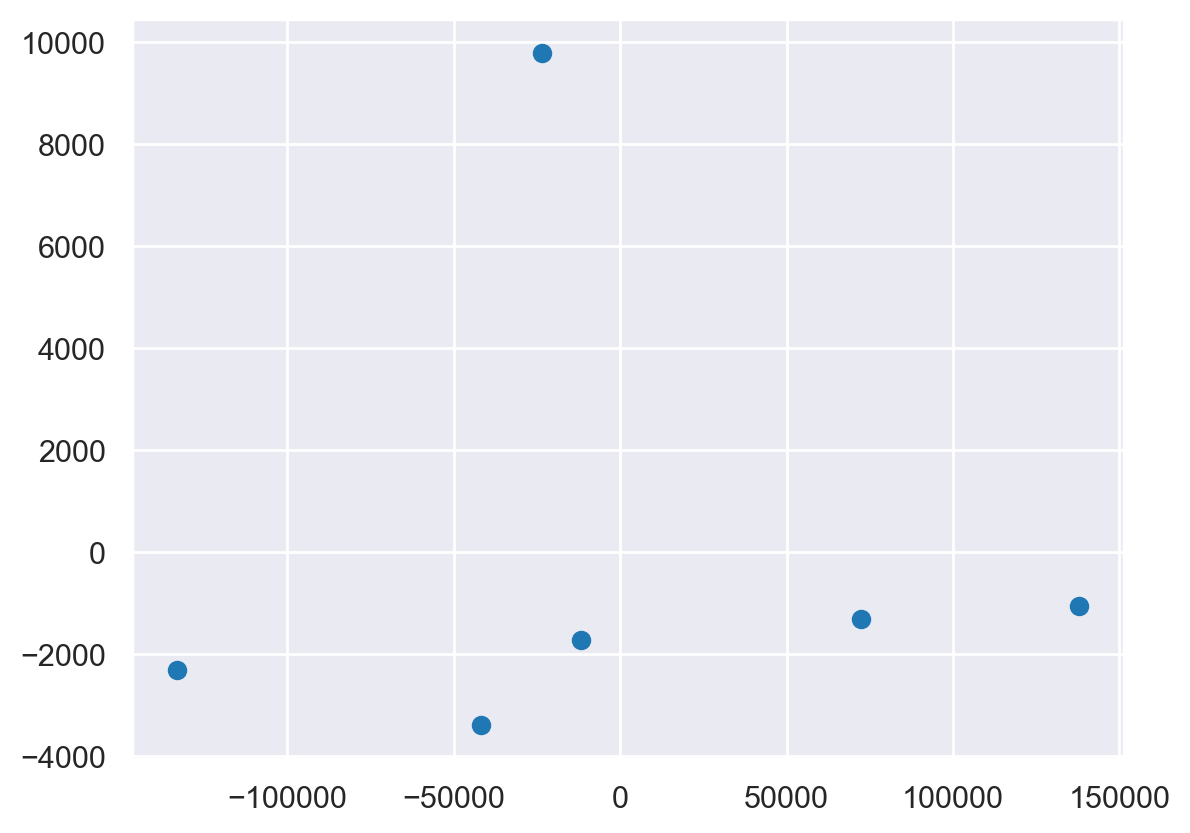

In [11]:
# PCA
pca = decomposition.PCA(n_components=2)
pca_wc_df = pca.fit_transform(wc_df)

# Plot
plt.scatter(pca_wc_df[:,0], pca_wc_df[:,1])
plt.show()

### Bag of words

#### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    *   Try with and without the n-gram parameter <br/><br/>

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

In [12]:
# n-gram parameter
vectorizer = CountVectorizer(ngram_range=(3,3))
cv_ng_df = pd.DataFrame(
    vectorizer.fit_transform(df['text']).toarray(), 
    columns=vectorizer.get_feature_names(), 
    index=df.index
)
cv_ng_df

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00 00 00,00 00 01,00 00 04,00 00 10,00 00 180,00 00 280,00 00 3f,00 00 after,00 00 and,00 00 or,...,ﬁrst mathematical publication,ﬁrst observed during,ﬁrst presented in,ﬁrst rigorous demonstration,ﬁrst that these,ﬁrst to second,ﬁve or less,ﬂexible through weeks,ﬂoating mate particles,ﬂoating particles eventually
corpus,,,,,,,,,,,,,,,,,,,,,
mythology,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
woodworking,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
robotics,43,4,1,0,1,1,2,1,0,0,...,0,0,1,0,0,0,0,0,0,0
hsm,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,1,0,0
health,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,1,0,1,1
portuguese,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# vectorization
vectorizer = CountVectorizer(vocabulary=words)
cv_df = pd.DataFrame(
    vectorizer.fit_transform(df['text']).toarray(), 
    columns=vectorizer.get_feature_names(), 
    index=df.index
)
cv_df

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,867,75,6,307,35,4,23,4,0
woodworking,5,8017,1,19,16,0,53,0,0
robotics,0,22,5321,25,33,50,3,2,0
hsm,28,17,2,1513,1174,2095,39,7,0
health,55,13,1,242,263,9,2178,4,0
portuguese,2,13,3,18,7,3,9,1061,0


#### 🚧 TODO: Why is this different? 

- Try to explain

- Give a simple example with the toy corpus below (with the same vocabulary)

In [14]:
test_text = (
    "myth wood robot history science mathematics health portuguese o "
    "myth wood robot history science mathematics health portuguese o"
)

In [15]:
test_wc_df = pd.DataFrame(index=range(1))
for w in words:
    test_wc_df[w] = test_text.count(w)
test_wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
0,2,2,2,2,2,2,2,2,14


In [16]:
vectorizer = CountVectorizer(vocabulary=words)
freqs = vectorizer.fit_transform([test_text]).toarray()
test_cv_df = pd.DataFrame(freqs, columns=vectorizer.get_feature_names_out())
test_cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
0,2,2,2,2,2,2,2,2,0


#### 🚧 TODO: Is this difference important?

• Visualize the PCAs of both models

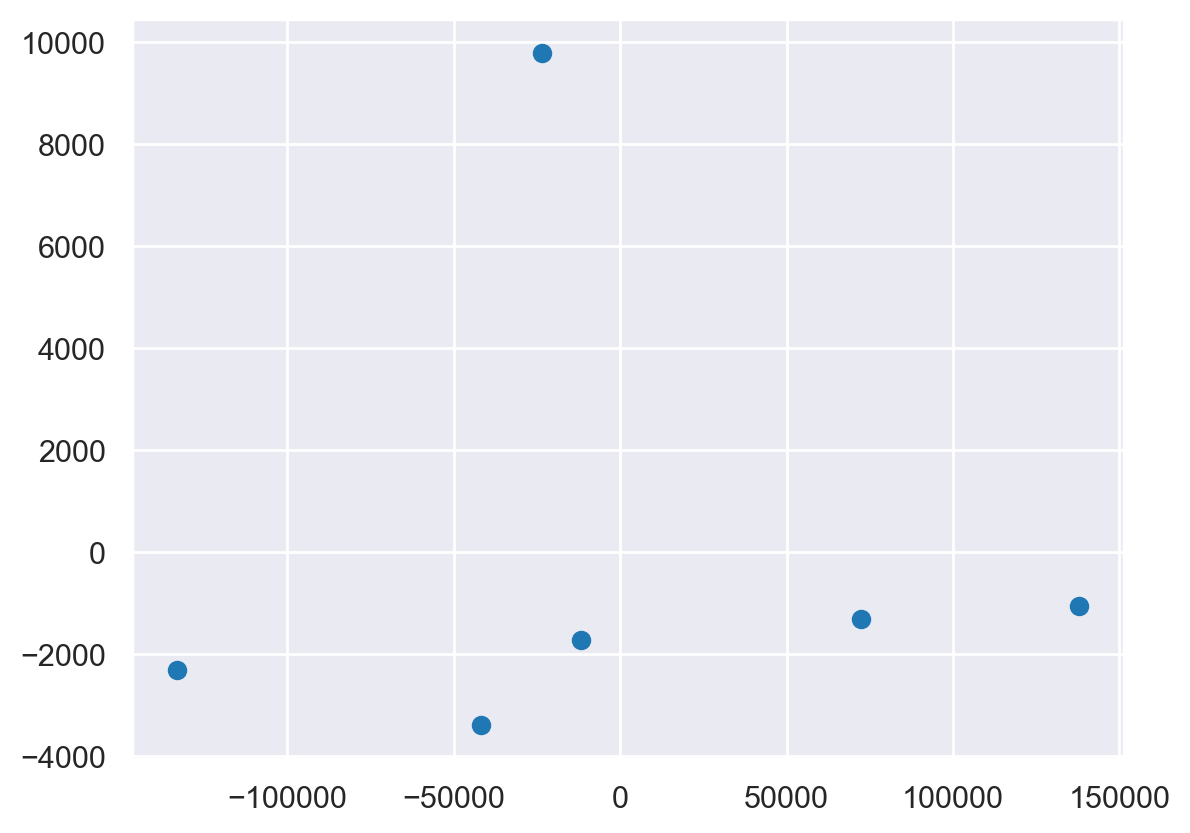

In [17]:
# PCA
pca = decomposition.PCA(n_components=2)
pca_wc_df = pca.fit_transform(wc_df)

# Plot
plt.scatter(pca_wc_df[:,0], pca_wc_df[:,1])
plt.show()

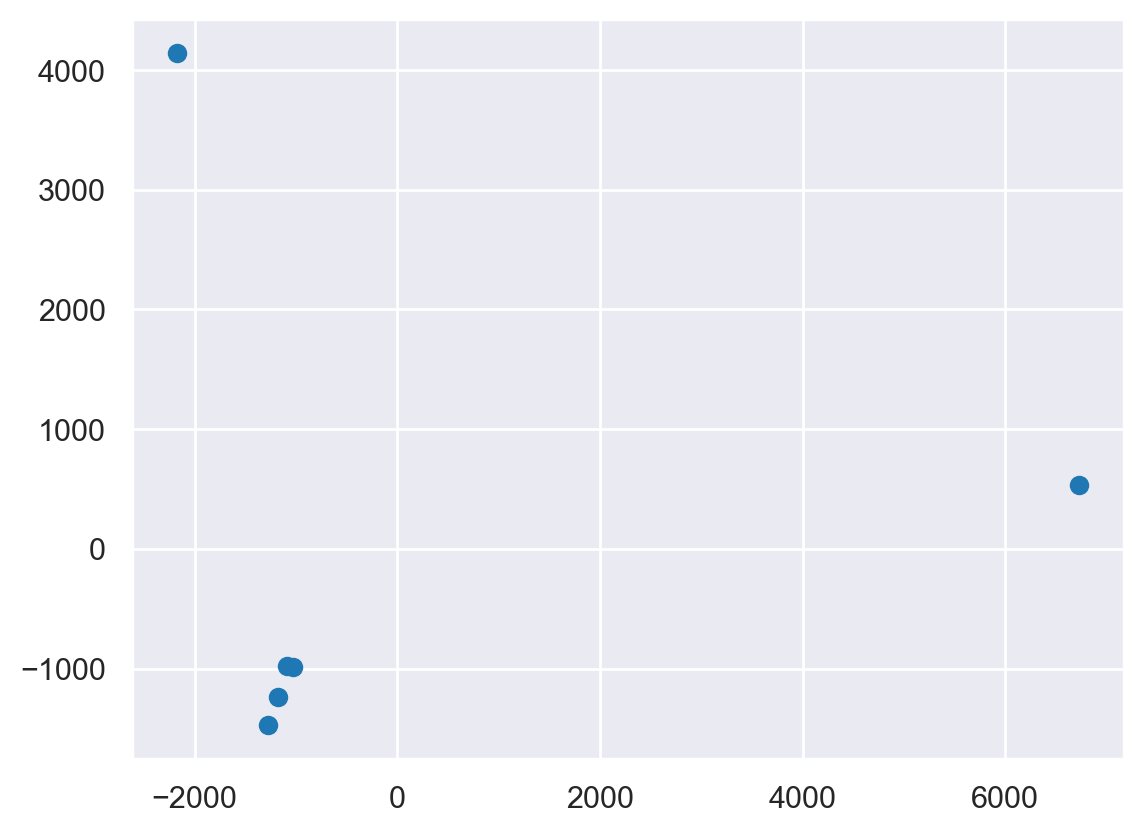

In [18]:
# PCA
pca = decomposition.PCA(n_components=2)
pca_cv_df = pca.fit_transform(cv_df)

# Plot
plt.scatter(pca_cv_df[:,0], pca_cv_df[:,1])
plt.show()

-----------

## Hold the corpus as individual documents

In [19]:
data = []
for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [20]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0
...,...,...,...
portuguese.stackexchange_0000001017,"Q:\n\n""pois não"" has an affirmative connotatio...",portuguese,5
portuguese.stackexchange_0000004609,"Q:\n\nPor que ""Teiú"" tem acento?\n\nMonossílab...",portuguese,5
portuguese.stackexchange_0000000484,"Q:\n\nRegional usage of ""guitarra"" and ""violão...",portuguese,5


#### 🚧 TODO: Plot (bar) the number of documents per category

<AxesSubplot:>

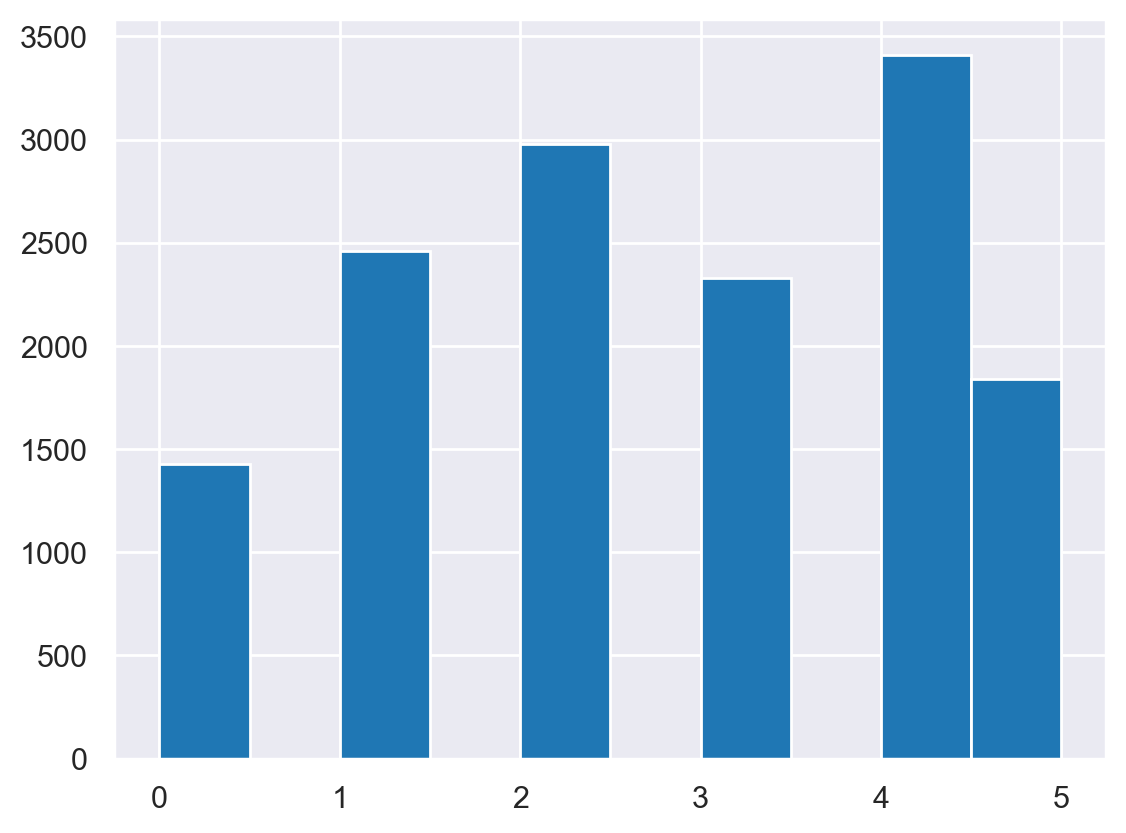

In [21]:
doc_df['cat_id'].hist()

#### 🚧 TODO: Boxplot the number of tokens per document

* With and without outliers

* Shortly explain the different values presented in a boxplot ([Wikipedia](https://en.wikipedia.org/wiki/Box_plot))

* Are the texts of signifcantly different length? Argue shortly.

In [22]:
# tokens 
doc_df['tokens_n'] = doc_df['text'].apply(lambda x: len(x.split()))

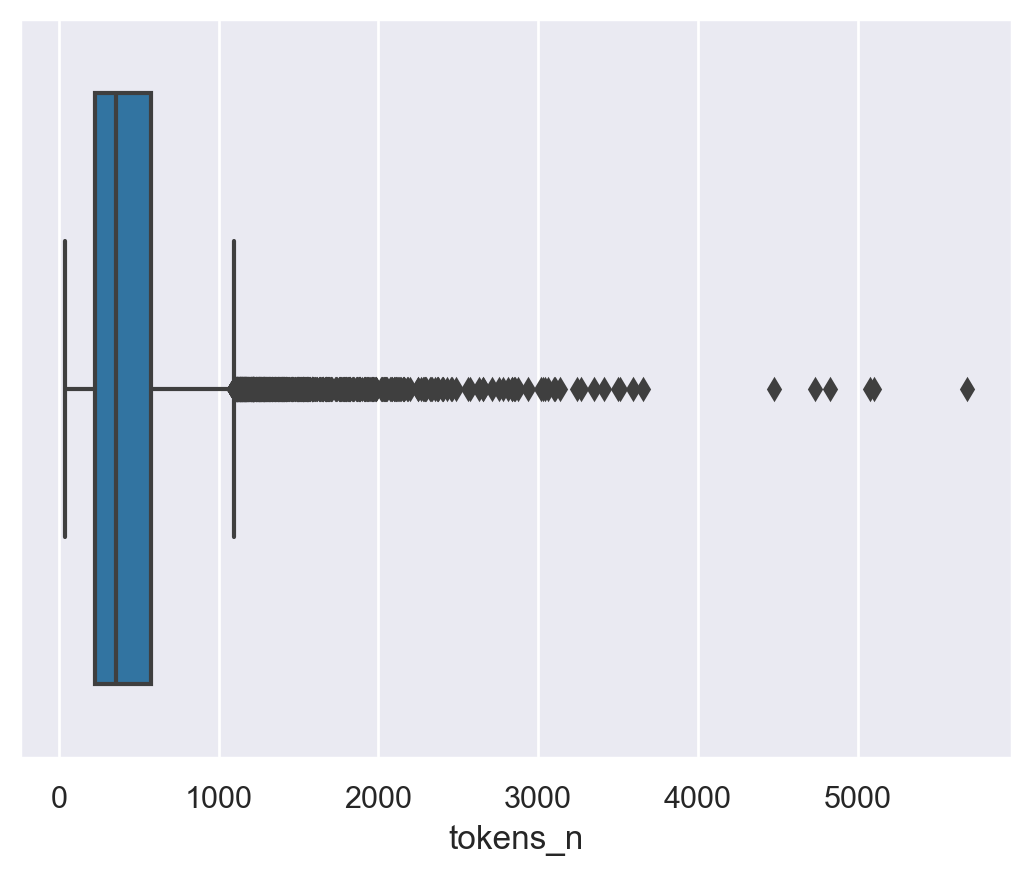

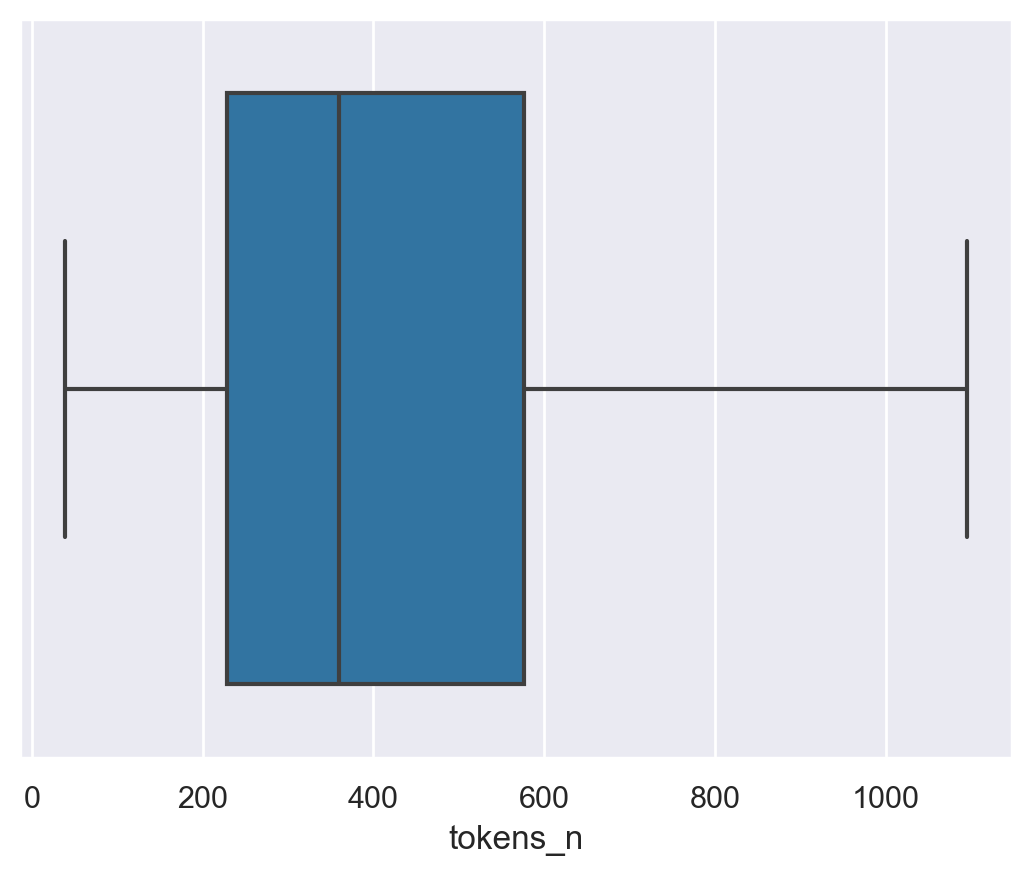

In [23]:
# Boxplot with outliers
sns.boxplot(x='tokens_n', data=doc_df)
plt.show()

# Boxplot without outliers
sns.boxplot(x='tokens_n', data=doc_df, showfliers=False)
plt.show()


### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [24]:
# index of the longest text
longest_index = doc_df['text'].str.split().str.len().idxmax()

print(doc_df.loc[longest_index, 'text'])
longest_df = doc_df.loc[longest_index,:]

Q:

Is Kline right that Cauchy believed that continuous functions must be differentiable?

Morris Kline, in Mathematical Thought from Ancient to Modern Time, writes in chapter 40 (The Installation of Rigor in Analysis), "Though Bolzano and Cauchy had rigorized (somewhat) the notions of continuity and the derivative, Cauchy and nearly all mathematicians of his era believed and many texts "proved" for the next fifty years that a continuous function must be differentiable."
Is it true that Cauchy believed that a continuous function must be differentiable as Kline claims?
Note 1.  As user Renfro correctly pointed out here the mathematician who attempted to "prove" that continuity implies differentiability was Ampere (rather than Cauchy).  The first one to confuse the two names seems to have been Boyer. I can't vouch for Kline's philosophy but at any rate his history can only be as good as the historians he relies upon, and in this case he seems to have copied the claim about Cauchy from Bo

### Vectorizing again

#### 🚧 TODO: See how many features we get if we don't restrict them

* Use again the `CountVectorizer` to vectorize the stackoverflow corpus

  * But use the whole vocabulary of the documents this time (**without** `vocabulary=words`)

  * Tell how many features are obtained

* Then limit the vocabulary to the 5000 most frequent words

* Apply and plot dimensionality reduction to 2 dimensions as prevously

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [25]:
ys = doc_df.cat_id.values

In [26]:
unconstrained_cv = CountVectorizer()
unconstrained_vectors = unconstrained_cv.fit_transform(doc_df['text'])
print("Number of features obtained without restriction:", len(unconstrained_cv.get_feature_names_out()))

Number of features obtained without restriction: 153122


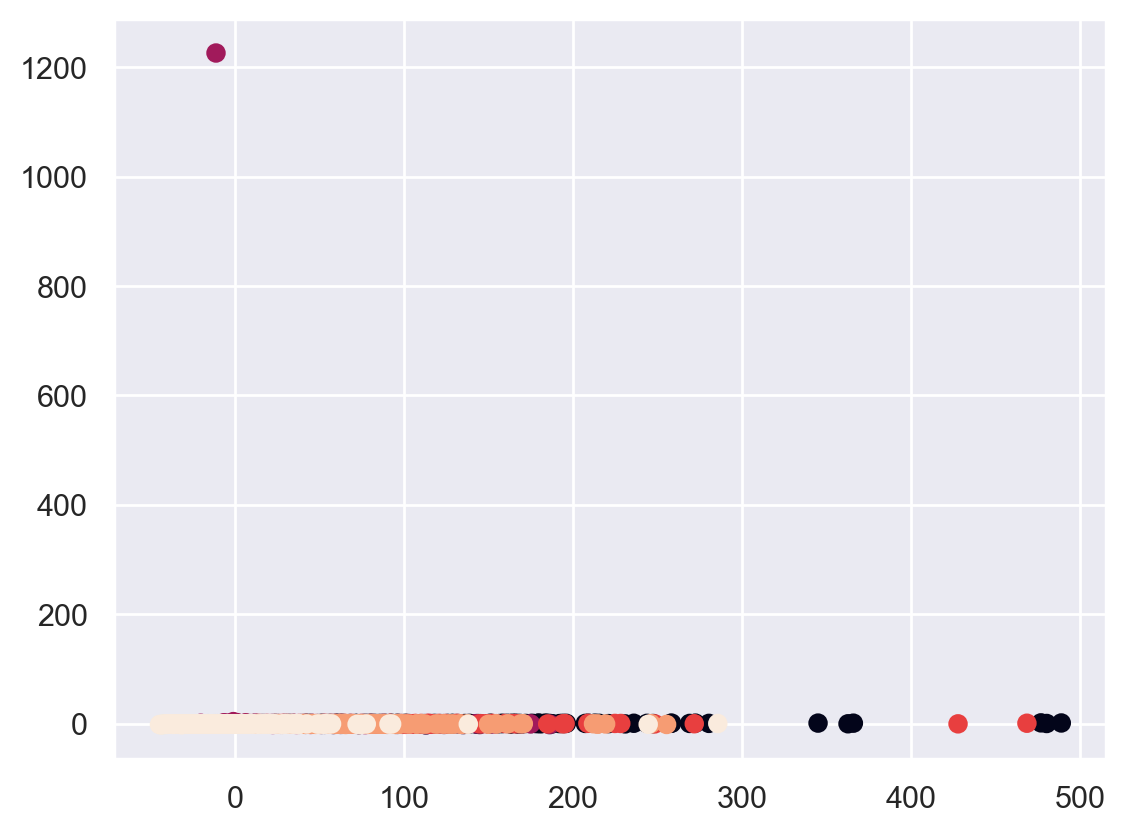

In [27]:
cv = CountVectorizer(max_features=5000)
vectors = cv.fit_transform(doc_df['text'])

pca = decomposition.PCA(n_components=2)
vectors_reduced = pca.fit_transform(vectors.toarray())

plt.scatter(vectors_reduced[:, 0], vectors_reduced[:, 1], c=ys)
plt.show()

#### 🚧 TODO: Outsider: find that guy!

* Use pandas to find the document corresponding to the outlier

* Print the correspoding text
  
* Tell what it contains (if you could figure it out)

* Remove the corresping raw from the dataframe and redo the dimensional reduction (and plot)

In [28]:
outlier_index = np.argmax(doc_df['tokens_n'])
print(doc_df['text'][outlier_index])

Q:

Is Kline right that Cauchy believed that continuous functions must be differentiable?

Morris Kline, in Mathematical Thought from Ancient to Modern Time, writes in chapter 40 (The Installation of Rigor in Analysis), "Though Bolzano and Cauchy had rigorized (somewhat) the notions of continuity and the derivative, Cauchy and nearly all mathematicians of his era believed and many texts "proved" for the next fifty years that a continuous function must be differentiable."
Is it true that Cauchy believed that a continuous function must be differentiable as Kline claims?
Note 1.  As user Renfro correctly pointed out here the mathematician who attempted to "prove" that continuity implies differentiability was Ampere (rather than Cauchy).  The first one to confuse the two names seems to have been Boyer. I can't vouch for Kline's philosophy but at any rate his history can only be as good as the historians he relies upon, and in this case he seems to have copied the claim about Cauchy from Bo

In [29]:
doc_df.index[outlier_index]

'hsm.stackexchange_0000003480'

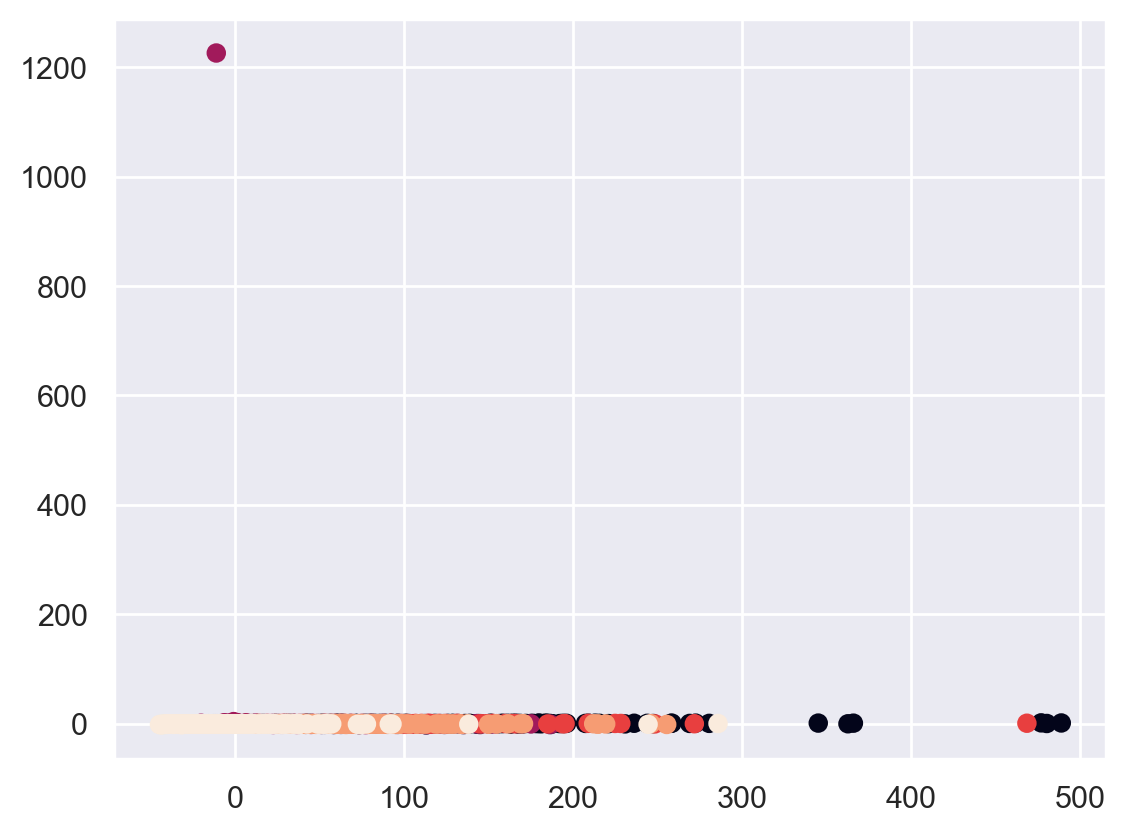

In [30]:
doc_df2 = doc_df.drop(doc_df.index[outlier_index])
ys2 = np.delete(ys, [outlier_index])

cv = CountVectorizer(max_features=5000)
vectors2 = cv.fit_transform(doc_df2['text'])

pca = decomposition.PCA(n_components=2)
vectors_reduced = pca.fit_transform(vectors2.toarray())

plt.scatter(vectors_reduced[:, 0], vectors_reduced[:, 1], c=ys2)
plt.show()

## Learning to distinguish text subjects

### Train and test sets

In [31]:
xs = vectors

In [32]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4336, 5000)


#### 🚧 TODO: Apply different algorithms to try predicting the category

* E.g., Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest, Support Vector Classifer.

* You could investigate [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements linear classifiers (e.g, SVM, logistic regression) with SGD training.

* Present a table with the results of the different algorithms (e.g., accuracy, precision, recall, f1-score) and their execution time (using, e.g., the magical command `%%timeit -n 1 -r 1`)

* Analyse 1 algorythm in detail (e.g., Logistic Regression)

  *   Try different parameters (possibly with a grid search)

  *   Present the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

  *   Present the confusion matrix of the best model

In [33]:
models = [
    LogisticRegression(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC()
]

for model in models:
    model.fit(train_xs, train_ys)
    y_pred = model.predict(test_xs)
    accuracy = accuracy_score(y_pred, test_ys)
    print(f"{model.__class__.__name__} accuracy: {accuracy:.3f}")


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression accuracy: 0.981
MultinomialNB accuracy: 0.972
DecisionTreeClassifier accuracy: 0.881
RandomForestClassifier accuracy: 0.967
SVC accuracy: 0.946


In [34]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10]}
logreg = LogisticRegression()
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(train_xs, train_ys)

print("Best parameters: ", grid_search.best_params_)
pca = decomposition.PCA(n_components)
y_pred = best_model.predict(test_xs)

print("Classification report:")
print(classification_report(test_ys, y_pred))

print("Confusion matrix:")
print(confusion_matrix(test_ys, y_pred))

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Best parameters:  {'C': 10}
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       420
           1       0.98      0.99      0.98       692
           2       0.99      0.98      0.99       927
           3       0.97      0.97      0.97       705
           4       0.98      0.98      0.98      1032
           5       1.00      0.99      0.99       560

    accuracy                           0.98      4336
   macro avg       0.98      0.98      0.98      4336
weighted avg       0.98      0.98      0.98      4336

Confusion matrix:
[[ 406    0    0   10    4    0]
 [   2  682    3    1    3    1]
 [   0    9  909    2    7    0]
 [  10    1    2  687    4    1]
 [   7    2    2    7 1014    0]
 [   0    1    1    0    3  555]]


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
from sklearn.model_selection import cross_validate

models = [
    LogisticRegression(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC()
]

scoring = {'accuracy': 'accuracy', 
           'f1_score': 'f1_weighted', 
           'precision': 'precision_weighted', 
           'recall': 'recall_weighted'}

for model in models:
    scores = cross_validate(model, xs, ys, cv=5, scoring=scoring)
    print('============================================================================')
    print(f"{model.__class__.__name__} cross validation scores:")
    print(f"Accuracy: {scores['test_accuracy'].mean():.3f} +/- {scores['test_accuracy'].std():.3f}")
    print(f"F1-score: {scores['test_f1_score'].mean():.3f} +/- {scores['test_f1_score'].std():.3f}")
    print()

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

LogisticRegression cross validation scores:
Accuracy: 0.981 +/- 0.001
F1-score: 0.981 +/- 0.001

MultinomialNB cross validation scores:
Accuracy: 0.973 +/- 0.002
F1-score: 0.972 +/- 0.002

DecisionTreeClassifier cross validation scores:
Accuracy: 0.884 +/- 0.006
F1-score: 0.884 +/- 0.006

RandomForestClassifier cross validation scores:
Accuracy: 0.968 +/- 0.003
F1-score: 0.967 +/- 0.003

SVC cross validation scores:
Accuracy: 0.949 +/- 0.005
F1-score: 0.949 +/- 0.005



### 🚧 TODO: Explain what model seems to work best

LogisticRegression

____